In [81]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

from textblob import TextBlob
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m.pham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m.pham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\m.pham\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
# Read the dataset
df = pd.read_csv("clean_data.csv")

In [4]:
df.head()

,ID,date_review,day_review,month_review,month_review_num,year_review,verified,name,month_fly,month_fly_num,...,seat_type,route,seat_comfort,cabit_serv,food,ground_service,wifi,money_value,recommended,review
0,0,2024-03-02,2,March,3,2024,True,T Collins,February,2.0,...,Business Class,Heathrow to Oslo,4.0,5.0,5.0,5.0,NaN,5,yes,I upgraded at check in to Club Europe seat 1D ...
1,1,2024-03-01,1,March,3,2024,True,Armando Castro,June,6.0,...,Economy Class,Sydney to Porto via Singapore / London,NaN,NaN,NaN,NaN,NaN,1,no,"I bought a return trip with BA, through Webjet..."
2,2,2024-02-29,29,February,2,2024,True,Simon Channon,February,2.0,...,Economy Class,London Heathrow to Lisbon,1.0,3.0,1.0,2.0,NaN,3,no,Poor from start to finish. Six months after pu...
3,3,2024-02-29,29,February,2,2024,True,C Allen,February,2.0,...,Premium Economy,Madrid to London via Buenos Aires,1.0,3.0,NaN,1.0,NaN,1,no,Communication and customer service non existen...
4,4,2024-02-23,23,February,2,2024,True,Peter Hansell,September,9.0,...,Economy Class,Pisa to London Heathrow,NaN,NaN,NaN,NaN,NaN,1,no,That was supposed to be my flight but it was c...


In [5]:
df.columns

Index(['ID', 'date_review', 'day_review', 'month_review', 'month_review_num',
       'year_review', 'verified', 'name', 'month_fly', 'month_fly_num',
       'year_fly', 'month_year_fly', 'country', 'aircraft', 'type',
       'seat_type', 'route', 'seat_comfort', 'cabit_serv', 'food',
       'ground_service', 'wifi', 'money_value', 'recommended', 'review'],
      dtype='object')

In [6]:
df = df[['seat_comfort', 'cabit_serv', 'food','ground_service', 'wifi','review', 'money_value','recommended']]

In [7]:
df.head()

,seat_comfort,cabit_serv,food,ground_service,wifi,review,money_value,recommended
0,4.0,5.0,5.0,5.0,NaN,I upgraded at check in to Club Europe seat 1D ...,5,yes
1,NaN,NaN,NaN,NaN,NaN,"I bought a return trip with BA, through Webjet...",1,no
2,1.0,3.0,1.0,2.0,NaN,Poor from start to finish. Six months after pu...,3,no
3,1.0,3.0,NaN,1.0,NaN,Communication and customer service non existen...,1,no
4,NaN,NaN,NaN,NaN,NaN,That was supposed to be my flight but it was c...,1,no


## General Word Frequency Analysis

In [23]:
def negative_word_cloud(df):
    # Combine all reviews into a single string
    reviews_text = ' '.join(df['review'].dropna())

    # Tokenize the text
    tokens = word_tokenize(reviews_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    # Perform sentiment analysis to identify negative words
    sid = SentimentIntensityAnalyzer()
    negative_words = [word for word in filtered_tokens if sid.polarity_scores(word)['compound'] < 0]

    # Initialize Porter Stemmer
    stemmer = PorterStemmer()

    # Example dictionary of similar words
    word_groups = {
        'delayed': 'delay',
        'cancelled': 'cancel'
        # Add more groups as needed
    }

    # Update negative words based on groups and stemming
    negative_words_grouped = []
    for word in negative_words:
        # Stem the word using Porter Stemmer
        stemmed_word = stemmer.stem(word)
        
        # Check if the stemmed word is in the word groups
        for group_word, group_root in word_groups.items():
            if group_word in stemmed_word:
                stemmed_word = group_root
                break
        
        # Add the stemmed word to the grouped negative words
        negative_words_grouped.append(stemmed_word)

    # Combine negative words into a single string
    negative_text_grouped = ' '.join(negative_words_grouped)

    # Create and generate the word cloud
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(negative_text_grouped)

    # Display the word cloud
    plt.figure(figsize=(8, 8), facecolor=None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad=0) 
    plt.show()

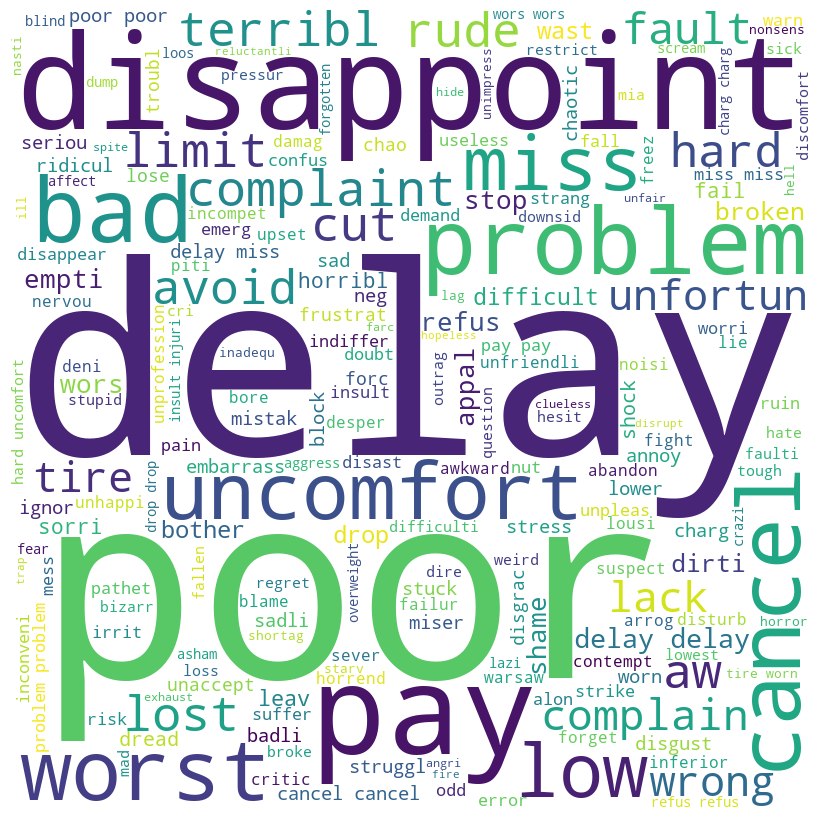

In [24]:
negative_word_cloud(df)

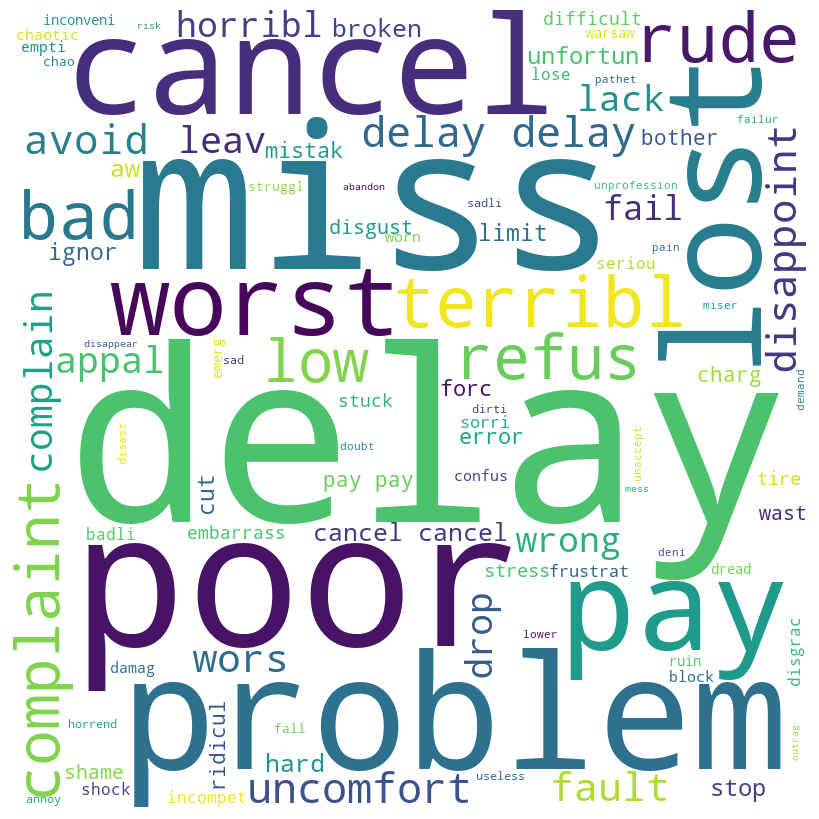

In [25]:
negative_word_cloud(df)

In [27]:
def plot_negative_bar(df):
    stemmer = PorterStemmer()

    # Example dictionary of similar words
    word_groups = {
        'delayed': 'delay',
        'cancelled': 'cancel'
        # Add more groups as needed
    }

    # Dictionary to store word frequencies
    word_freq = {}

    # Update word frequencies based on groups and stemming
    for word in negative_words:
        # Stem the word using Porter Stemmer
        stemmed_word = stemmer.stem(word)
        
        # Check if the stemmed word is in the word groups
        for group_word, group_root in word_groups.items():
            if group_word in stemmed_word:
                stemmed_word = group_root
                break
        
        # Update word frequency dictionary
        word_freq[stemmed_word] = word_freq.get(stemmed_word, 0) + 1

    # Create a DataFrame from the word frequency dictionary
    word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])

    # Sort the DataFrame by frequency
    word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

    # Print the list of common negative words and their occurrences
    print(word_freq_df)

    # Plot the occurrences using a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(word_freq_df['Word'][:10], word_freq_df['Frequency'][:10], color='red')
    plt.xlabel('Negative Words')
    plt.ylabel('Frequency')
    plt.title('Top 10 Common Negative Words')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

           Word  Frequency
7         delay        886
3          poor        648
11          pay        475
16       cancel        442
49   disappoint        425
..          ...        ...
506     undecid          1
508       slash          1
275     hapless          1
267     nastier          1
629      grimac          1

[630 rows x 2 columns]


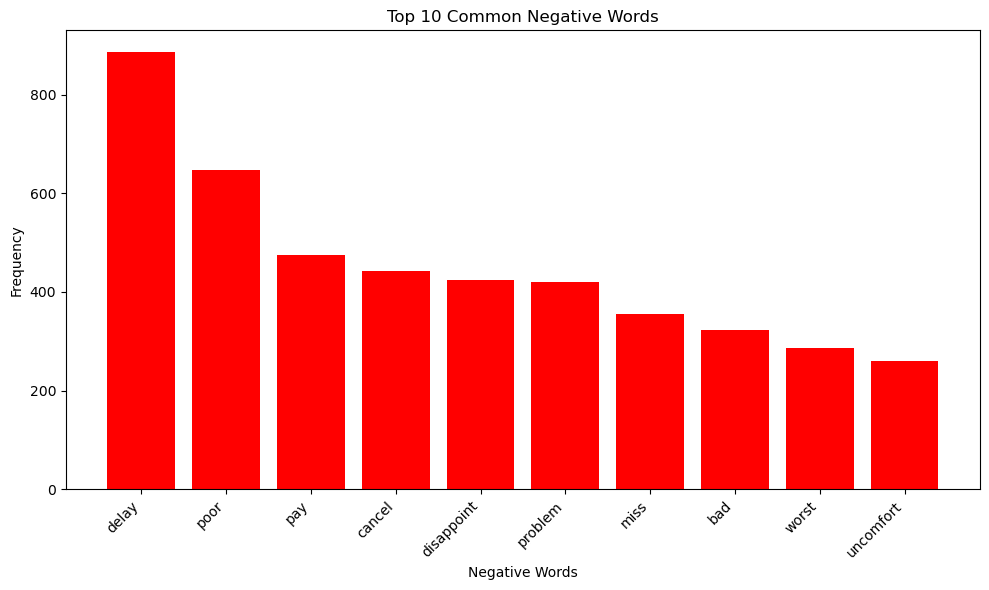

In [28]:
plot_negative_bar(df)

In [72]:
def calculate_percentage(df, *keywords):
    """
    Calculate the percentage of flights that contain specific keywords in the 'review' column.

    Parameters:
    df (DataFrame): DataFrame containing a 'review' column.
    *keywords: Variable length list containing the keywords to search for in the 'review' column.

    Returns:
    None
    """
    for keyword_list in keywords:
        # Function to check if the review contains all the keywords in the list
        def check_keyword(review):
            return all(kw.lower() in review.lower() for kw in keyword_list)

        # Apply the function to create the column
        df['_'.join(keyword_list).lower()] = df['review'].apply(check_keyword).astype(int)
        
        # Calculate the percentage and round to two decimal places
        percentage = round((df['_'.join(keyword_list).lower()].mean()) * 100, 2)

        print(f"Percentage of flights that have {', '.join(keyword_list)} problem: {percentage}%")

calculate_percentage(df, ["lost", "luggage"],['miss','wait'], ["delay"],['cancel'], ['uncomfortable','seat'],['staff'])

Percentage of flights that have lost, luggage problem: 1.38%
Percentage of flights that have miss, wait problem: 2.39%
Percentage of flights that have delay problem: 18.09%
Percentage of flights that have cancel problem: 9.02%
Percentage of flights that have uncomfortable, seat problem: 5.72%
Percentage of flights that have staff problem: 30.39%


In [84]:
def print_sentences_near_word(df, input_word):
    """
    Print the sentences containing the input word in the 'review' DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing a 'review' column.
    input_word (str): The word to find the nearest sentences from.

    Returns:
    None
    """
    # Iterate through each review in the DataFrame
    for review in df['review']:
        # Split the review into sentences
        review_sentences = review.split('.')

        # Iterate through each sentence in the review
        for sentence in review_sentences:
            # Check if the input word is in the sentence
            if input_word.lower() in sentence.lower():
                # Print the sentence with surrounding context
                print(sentence.strip())

print_sentences_near_word(df, "staff")

The check-in at the airport was very quick and smooth, with friendly staff
During the flight I felt that a staff member was very unprofessional towards me
It took nearly 50 minutes of phone calls and numerous staff to check us in for a redemption flight through our account
Baggage of other flights arriving after had been delivered whereas the baggage staff on airport had no clue and information as to why baggage of this flight hasn’t arrived
Ground staff member at YVR was extremely helpful & courteous
Flight departed on time but unfortunately upon landing at LHR we were unable to deplane for quite some time due to a staffing issue at LHR which so not the fault of the airline, and we were given frequent updates on the situation from the flight manager & the flight deck
Staff look tired and overworked, trying their best
As we were connecting, we had little interaction with ground staff - staff in the lounge were friendly and helpful
Whilst I was waiting in line another passenger went up 

## Sentiment Analysis

In [12]:
# Define a function to calculate sentiment polarity using TextBlob
def calculate_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

In [13]:
# Apply the function to your review column
df['sentiment_score'] = df['review'].apply(calculate_sentiment)

In [14]:
df['sentiment_score'].describe()

count    3758.000000
mean        0.090564
std         0.179188
min        -0.766667
25%        -0.020946
50%         0.079611
75%         0.200516
max         0.800000
Name: sentiment_score, dtype: float64

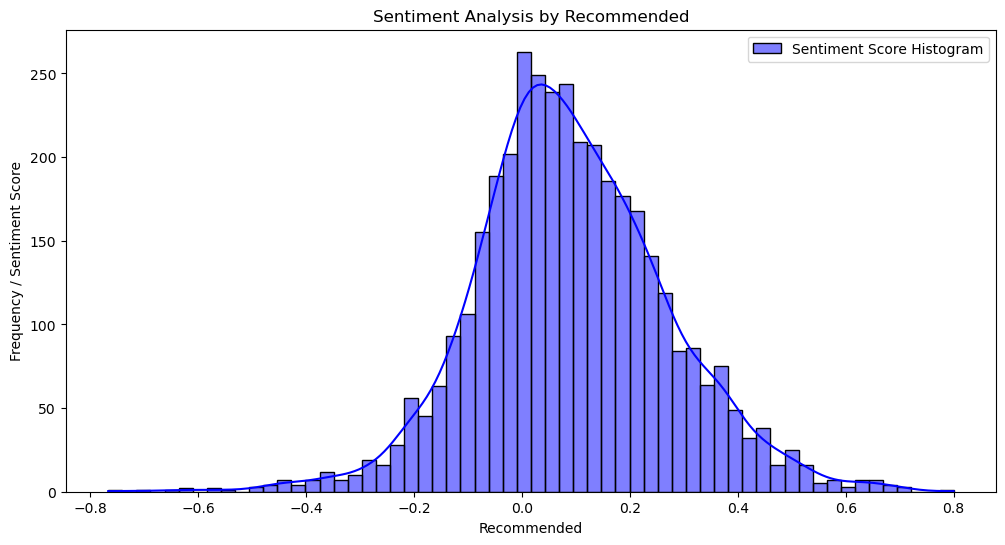

In [15]:
# Create a combo chart
plt.figure(figsize=(12, 6))

# Plot histogram with kernel density estimate
sns.histplot(df['sentiment_score'], bins=60, color='blue', kde=True, label='Sentiment Score Histogram')

plt.title('Sentiment Analysis by Recommended')
plt.xlabel('Recommended')
plt.ylabel('Frequency / Sentiment Score')
plt.legend()

plt.show()


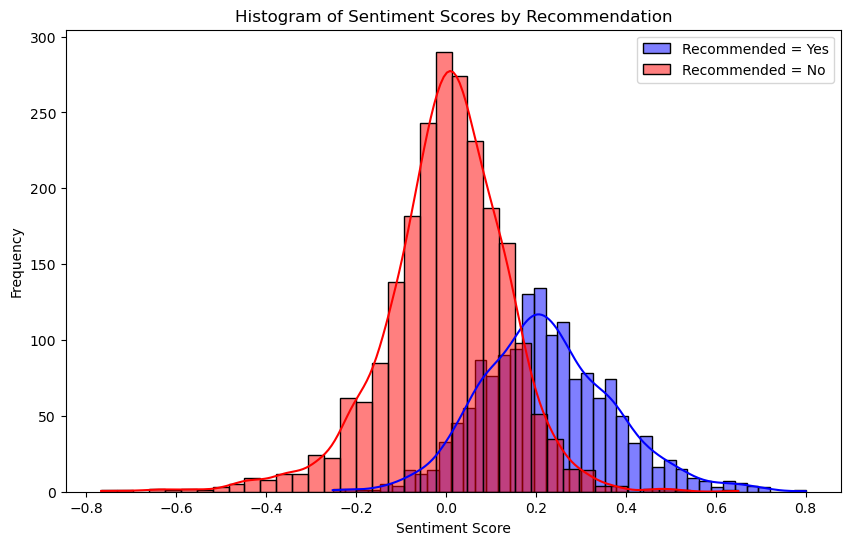

In [16]:
# Create histograms for sentiment scores based on 'Recommended' column
plt.figure(figsize=(10, 6))

sns.histplot(df[df['recommended'] == 'yes']['sentiment_score'], bins=40, color='blue', label='Recommended = Yes', kde=True)
sns.histplot(df[df['recommended'] == 'no']['sentiment_score'], bins=40, color='red', label='Recommended = No', kde=True)

plt.title('Histogram of Sentiment Scores by Recommendation')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [17]:
# Group sentiment score by Recommended column
grouped_data = df.groupby('recommended')['sentiment_score'].agg(['max', 'min', 'mean', 'median']).reset_index()
grouped_data

,recommended,max,min,mean,median
0,no,0.65,-0.766667,0.00042,0.007576
1,yes,0.80,-0.251667,0.22432,0.214167


In [18]:
df.head()

,seat_comfort,cabit_serv,food,ground_service,wifi,review,money_value,recommended,delay,cancel,sentiment_score
0,4.0,5.0,5.0,5.0,NaN,I upgraded at check in to Club Europe seat 1D ...,5,yes,0,0,0.694231
1,NaN,NaN,NaN,NaN,NaN,"I bought a return trip with BA, through Webjet...",1,no,0,0,0.137037
2,1.0,3.0,1.0,2.0,NaN,Poor from start to finish. Six months after pu...,3,no,1,0,-0.089286
3,1.0,3.0,NaN,1.0,NaN,Communication and customer service non existen...,1,no,0,0,0.000000
4,NaN,NaN,NaN,NaN,NaN,That was supposed to be my flight but it was c...,1,no,0,1,-0.047222


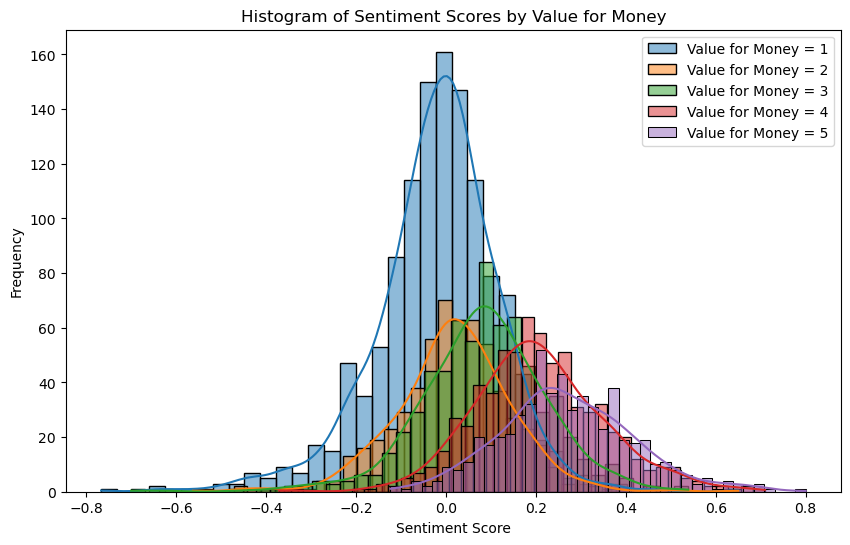

In [19]:
plt.figure(figsize=(10, 6))

# Plot histograms for 'Value for Money' scores
for value in range(1, 6):
    sns.histplot(df[df['money_value'] == value]['sentiment_score'], bins=40, label=f'Value for Money = {value}', kde=True)

plt.title('Histogram of Sentiment Scores by Value for Money')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [20]:
# Map 'yes' to 1 and 'no' to 0 in the 'Recommended' column
df['recommended'] = df['recommended'].map({'yes': 1, 'no': 0})

## Hearthrow experience Analysis

In [65]:
london_df = pd.read_csv('london_airport.csv')

In [68]:
london_df.columns

Index(['Unnamed: 0', 'verified', 'month_fly', 'month_fly_num', 'year_fly',
       'month_year_fly', 'country', 'type', 'route', 'ground_service',
       'money_value', 'recommended', 'review', 'origin', 'destination',
       'transit'],
      dtype='object')

In [70]:
london_df = london_df[['month_fly', 'month_fly_num', 'year_fly',
       'month_year_fly','verified','review']]

In [71]:
london_df

,month_fly,month_fly_num,year_fly,month_year_fly,verified,review
0,February,2.0,2024.0,2024-02-01,True,Poor from start to finish. Six months after pu...
1,February,2.0,2024.0,2024-02-01,False,We have flown BA five times from western USA t...
2,February,2.0,2024.0,2024-02-01,True,London Heathrow to Istanbul at the start of th...
3,February,2.0,2024.0,2024-02-01,False,Another case of reviewing British Airways flig...
4,October,10.0,2023.0,2023-10-01,False,I did not actually get to fly with BA as they ...
...,...,...,...,...,...,...
630,June,6.0,2015.0,2015-06-01,False,"Returning from Chicago to Berlin, the overall ..."
631,June,6.0,2015.0,2015-06-01,False,On this occasion my partner and I experienced ...
632,June,6.0,2015.0,2015-06-01,False,Check in at Tegel was a disaster and ludicrous...
633,November,11.0,2014.0,2014-11-01,False,After my flight to Vienna with BA I was hoping...


In [73]:
# Apply the function to your review column
london_df['sentiment_score'] = london_df['review'].apply(calculate_sentiment)

C:\Users\m.pham\AppData\Local\Temp\ipykernel_17396\3193052735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_df['sentiment_score'] = london_df['review'].apply(calculate_sentiment)


In [75]:
london_df['sentiment_score'].describe()

count    635.000000
mean      -0.012653
std        0.143690
min       -0.633333
25%       -0.083444
50%       -0.005303
75%        0.075799
max        0.650000
Name: sentiment_score, dtype: float64

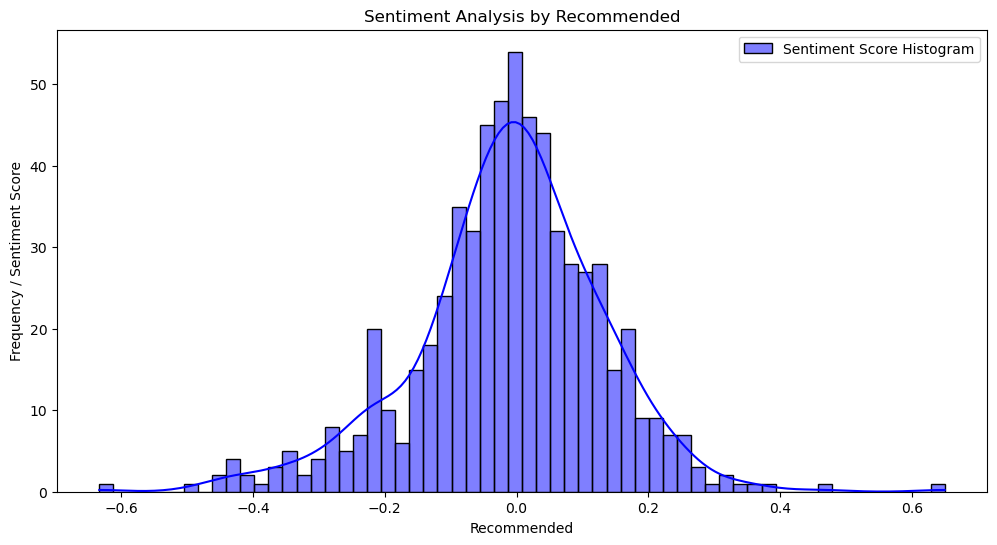

In [76]:
# Create a combo chart
plt.figure(figsize=(12, 6))

# Plot histogram with kernel density estimate
sns.histplot(london_df['sentiment_score'], bins=60, color='blue', kde=True, label='Sentiment Score Histogram')

plt.title('Sentiment Analysis by Recommended')
plt.xlabel('Recommended')
plt.ylabel('Frequency / Sentiment Score')
plt.legend()

plt.show()


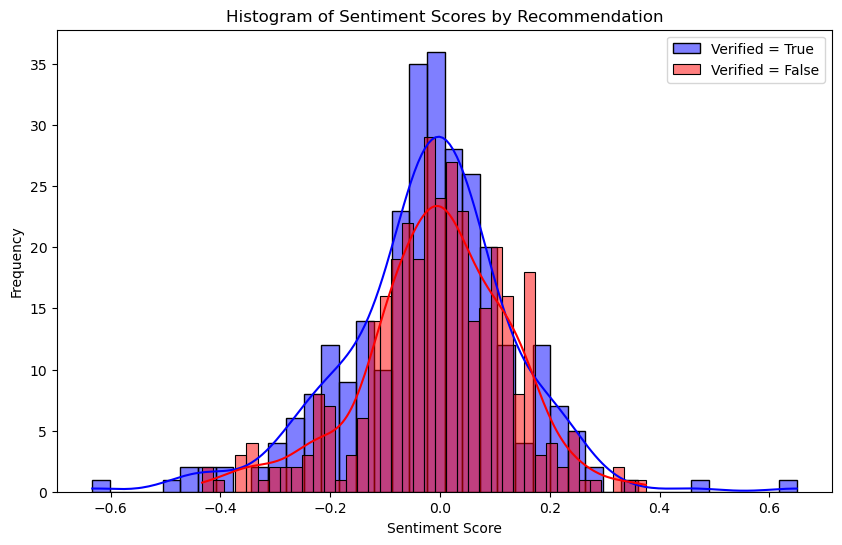

In [78]:
# Create histograms for sentiment scores based on 'Recommended' column
plt.figure(figsize=(10, 6))

sns.histplot(london_df[london_df['verified'] == True]['sentiment_score'], bins=40, color='blue', label='Verified = True', kde=True)
sns.histplot(london_df[london_df['verified'] == False]['sentiment_score'], bins=40, color='red', label='Verified = False', kde=True)

plt.title('Histogram of Sentiment Scores by Recommendation')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [89]:
calculate_percentage(london_df[london_df['sentiment_score']<0], ["delay"],['cancel'], ['staff'],['wait'])

Percentage of flights that have delay problem: 33.02%
Percentage of flights that have cancel problem: 17.28%
Percentage of flights that have staff problem: 33.95%
Percentage of flights that have wait problem: 24.69%


In [88]:
print_sentences_near_word(london_df[london_df['sentiment_score']<0], "staff")

Unfortunately we were stranded in the plane and waited a very long time to disembark the plane due to lack of staff or slot shortage (it’s a common problem with BA at Heathrow)
Cabin staff don't bother implementing their own rules
Anyone with a connecting flight couldn't rebook on the application because the app wouldn't disassociate our first flight with the connecting one in London and the staff saw this but still refused to help us
I guess staff are badly paid from their terrible attitude and service
The staff are very rude and not trained properly
2) Staff demanded that we check in our carry on luggage even though we met our carry on allowance
3) Staff were quite unpleasant
Why don't you hire enough personnel to fulfil your staff demand
Most customers she serves have a complaint Staff don't care as poor service and unhappy customers is a routine occurrence
The ground staff were not helpful
The British Airways staff said that we could go book any hotel up to 200 pounds and we would 

## Topic Modelling

In [112]:
# Tokenize the reviews and remove stopwords
stop_words = set(stopwords.words('english'))
tokenized_reviews = [word_tokenize(review.lower()) for review in london_df['review']]
reviews = [[word for word in review if word.isalnum() and word not in stop_words] for review in tokenized_reviews]

# Train the Word2Vec model
word2vec_model = Word2Vec(reviews, vector_size=300, window=5, min_count=1, workers=4)

# Define keywords indicative of each category
staff_keywords = ['not_helpful', 'unprofessional', 'rude']
understaff_keywords = ['lack', 'useless']  # Adding 'useless' as a similar word

# Function to categorize reviews based on word vectors
def categorize_review(review):
    review_tokens = [word for word in word_tokenize(review.lower()) if word.isalnum() and word not in stop_words]

    # Calculate similarity with staff keywords
    staff_similarities = [word2vec_model.wv.similarity(keyword, word) for keyword in staff_keywords for word in review_tokens if word in word2vec_model.wv.key_to_index and keyword in word2vec_model.wv.key_to_index]
    staff_similarity_score = sum(staff_similarities) / len(staff_similarities) if staff_similarities else 0

    # Calculate similarity with understaff keywords
    understaff_similarities = [word2vec_model.wv.similarity(keyword, word) for keyword in understaff_keywords for word in review_tokens if word in word2vec_model.wv.key_to_index and keyword in word2vec_model.wv.key_to_index]
    understaff_similarity_score = sum(understaff_similarities) / len(understaff_similarities) if understaff_similarities else 0

    # Categorize review based on similarity scores
    if staff_similarity_score > understaff_similarity_score:
        return 'Staff Problems'
    elif understaff_similarity_score > staff_similarity_score:
        return 'Understaff Problems'
    else:
        return 'Other Problems'

# Apply categorization function to each review
london_df['review_topic'] = london_df['review'].apply(categorize_review)

# Display the distribution of topics
print(london_df['review_topic'].value_counts())

review_topic
Understaff Problems    633
Staff Problems           2
Name: count, dtype: int64


In [111]:
# target_sentence = "staff"
# london_df.loc[london_df['review'].str.contains(target_sentence)][['review','review_topic']]

,review,review_topic
2,London Heathrow to Istanbul at the start of th...,Understaff Problems
16,I recently had a delay on British Airways from...,Understaff Problems
19,Booked a flight from Bucharest to Manchester w...,Understaff Problems
27,BA has a real problem with boarding it's fligh...,Understaff Problems
29,"Just returned from Chicago, flew out 10 days a...",Understaff Problems
...,...,...
621,"The staff were great, food was pretty good, th...",Understaff Problems
623,"Day trip to Vienna, used BA Economy as their B...",Understaff Problems
626,Having encouraged passengers to check-in onlin...,Understaff Problems
627,If I could give it a Zero I would. From the mo...,Understaff Problems


In [113]:
def filter_review_sentences_with_staff(review):
    """
    Modify the review column to only include sentences containing the word 'staff'.

    Parameters:
    review (str): The review text.

    Returns:
    str: The modified review text containing only sentences with the word 'staff'.
    """
    from nltk.tokenize import sent_tokenize

    # Tokenize the review into sentences
    sentences = sent_tokenize(review)

    # Filter sentences containing the word 'staff'
    filtered_sentences = [sentence for sentence in sentences if 'staff' in sentence.lower()]

    # Join the filtered sentences into a single string
    modified_review = ' '.join(filtered_sentences)

    return modified_review

# Apply the function to modify the 'review' column
london_df['staff_review'] = london_df['review'].apply(filter_review_sentences_with_staff)

In [114]:
target_sentence = "staff"
staff_problems = london_df.loc[london_df['staff_review'].str.contains(target_sentence)][['staff_review','review_topic']]
staff_problems.to_csv('staff_problems.csv')